In [26]:
import sys
import os
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt

import pandas as pd
from time import time

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd

sys.path.insert(0, "../src/")

from landprice_merger import (
    zensus_landprice_merger,
    landprice_neighborhood_merger,
    combine_landprice_with_geodata,
)
from csv_merger import combine_csvs
from principal_component_analysis import combine_PCA_datasets


pd.options.mode.chained_assignment = None

In [4]:
cities = ["Berlin", "Bremen", "Dresden", "Frankfurt_am_Main", "Köln"]

main_path = os.path.join(os.getcwd(), "..")

path_zensus = os.path.join(main_path, "res", "data", "DLR", "2 Zensus")
path_land = os.path.join(main_path, "res", "data", "DLR", "1 Land Prices")
path_neigh = os.path.join(main_path, "res", "data", "DLR", "3 Neighborhoods")


In [20]:
ls_df_cities = []
ls_df_cities_important_features = []

for i in range(len(cities)):
    
    df_zensus = combine_csvs(str_path=path_zensus)

    gdf_zensus, important_features_city_source = combine_PCA_datasets(
    df_zensus = df_zensus, str_city=cities[i], str_path=path_zensus
    )

    df_land_prices = combine_csvs(str_path=path_land)

    gdf_landprices = combine_landprice_with_geodata(
        df_landprice=df_land_prices, str_city=cities[i], str_path=path_land
    )

    gdf_landprices_names = landprice_neighborhood_merger(
        gdf_landprice=gdf_landprices, str_city=cities[i], str_path_neigh=path_neigh
    )

    result = zensus_landprice_merger(
    gdf_landprices=gdf_landprices_names, gdf_zensus=gdf_zensus
    )

    result_grouped = result.drop(columns = ["Grid_Code", 'City_Code', "geometry", 'City_Name', 'City']).groupby("Neighborhood_Name").median().reset_index()

    
    land_price_grid = gpd.read_file(path_neigh + "/Neighborhoods_" + cities[i] + ".gpkg")
    result_grouped = result_grouped.merge(land_price_grid, on = ["Neighborhood_Name", "Neighborhood_FID"])
    result_grouped_lm = result_grouped.drop(columns = ["Neighborhood_Name"])

    ls_df_cities.append(result_grouped_lm)
    ls_df_cities_important_features.append(important_features_city_source)


for i in range(len(ls_df_cities)):
    ls_df_cities[i].to_csv("D:/ifo_hack/programming/Geo-paw-sitioning" + cities[i] + ".csv", index = False)

### Berlin

In [253]:
df_berlin = ls_df_cities[0].drop(columns = ["geometry", "City_Name", "City_Code", "index_right", "Neighborhood_FID", "District_Name"])

<function matplotlib.pyplot.show(close=None, block=None)>

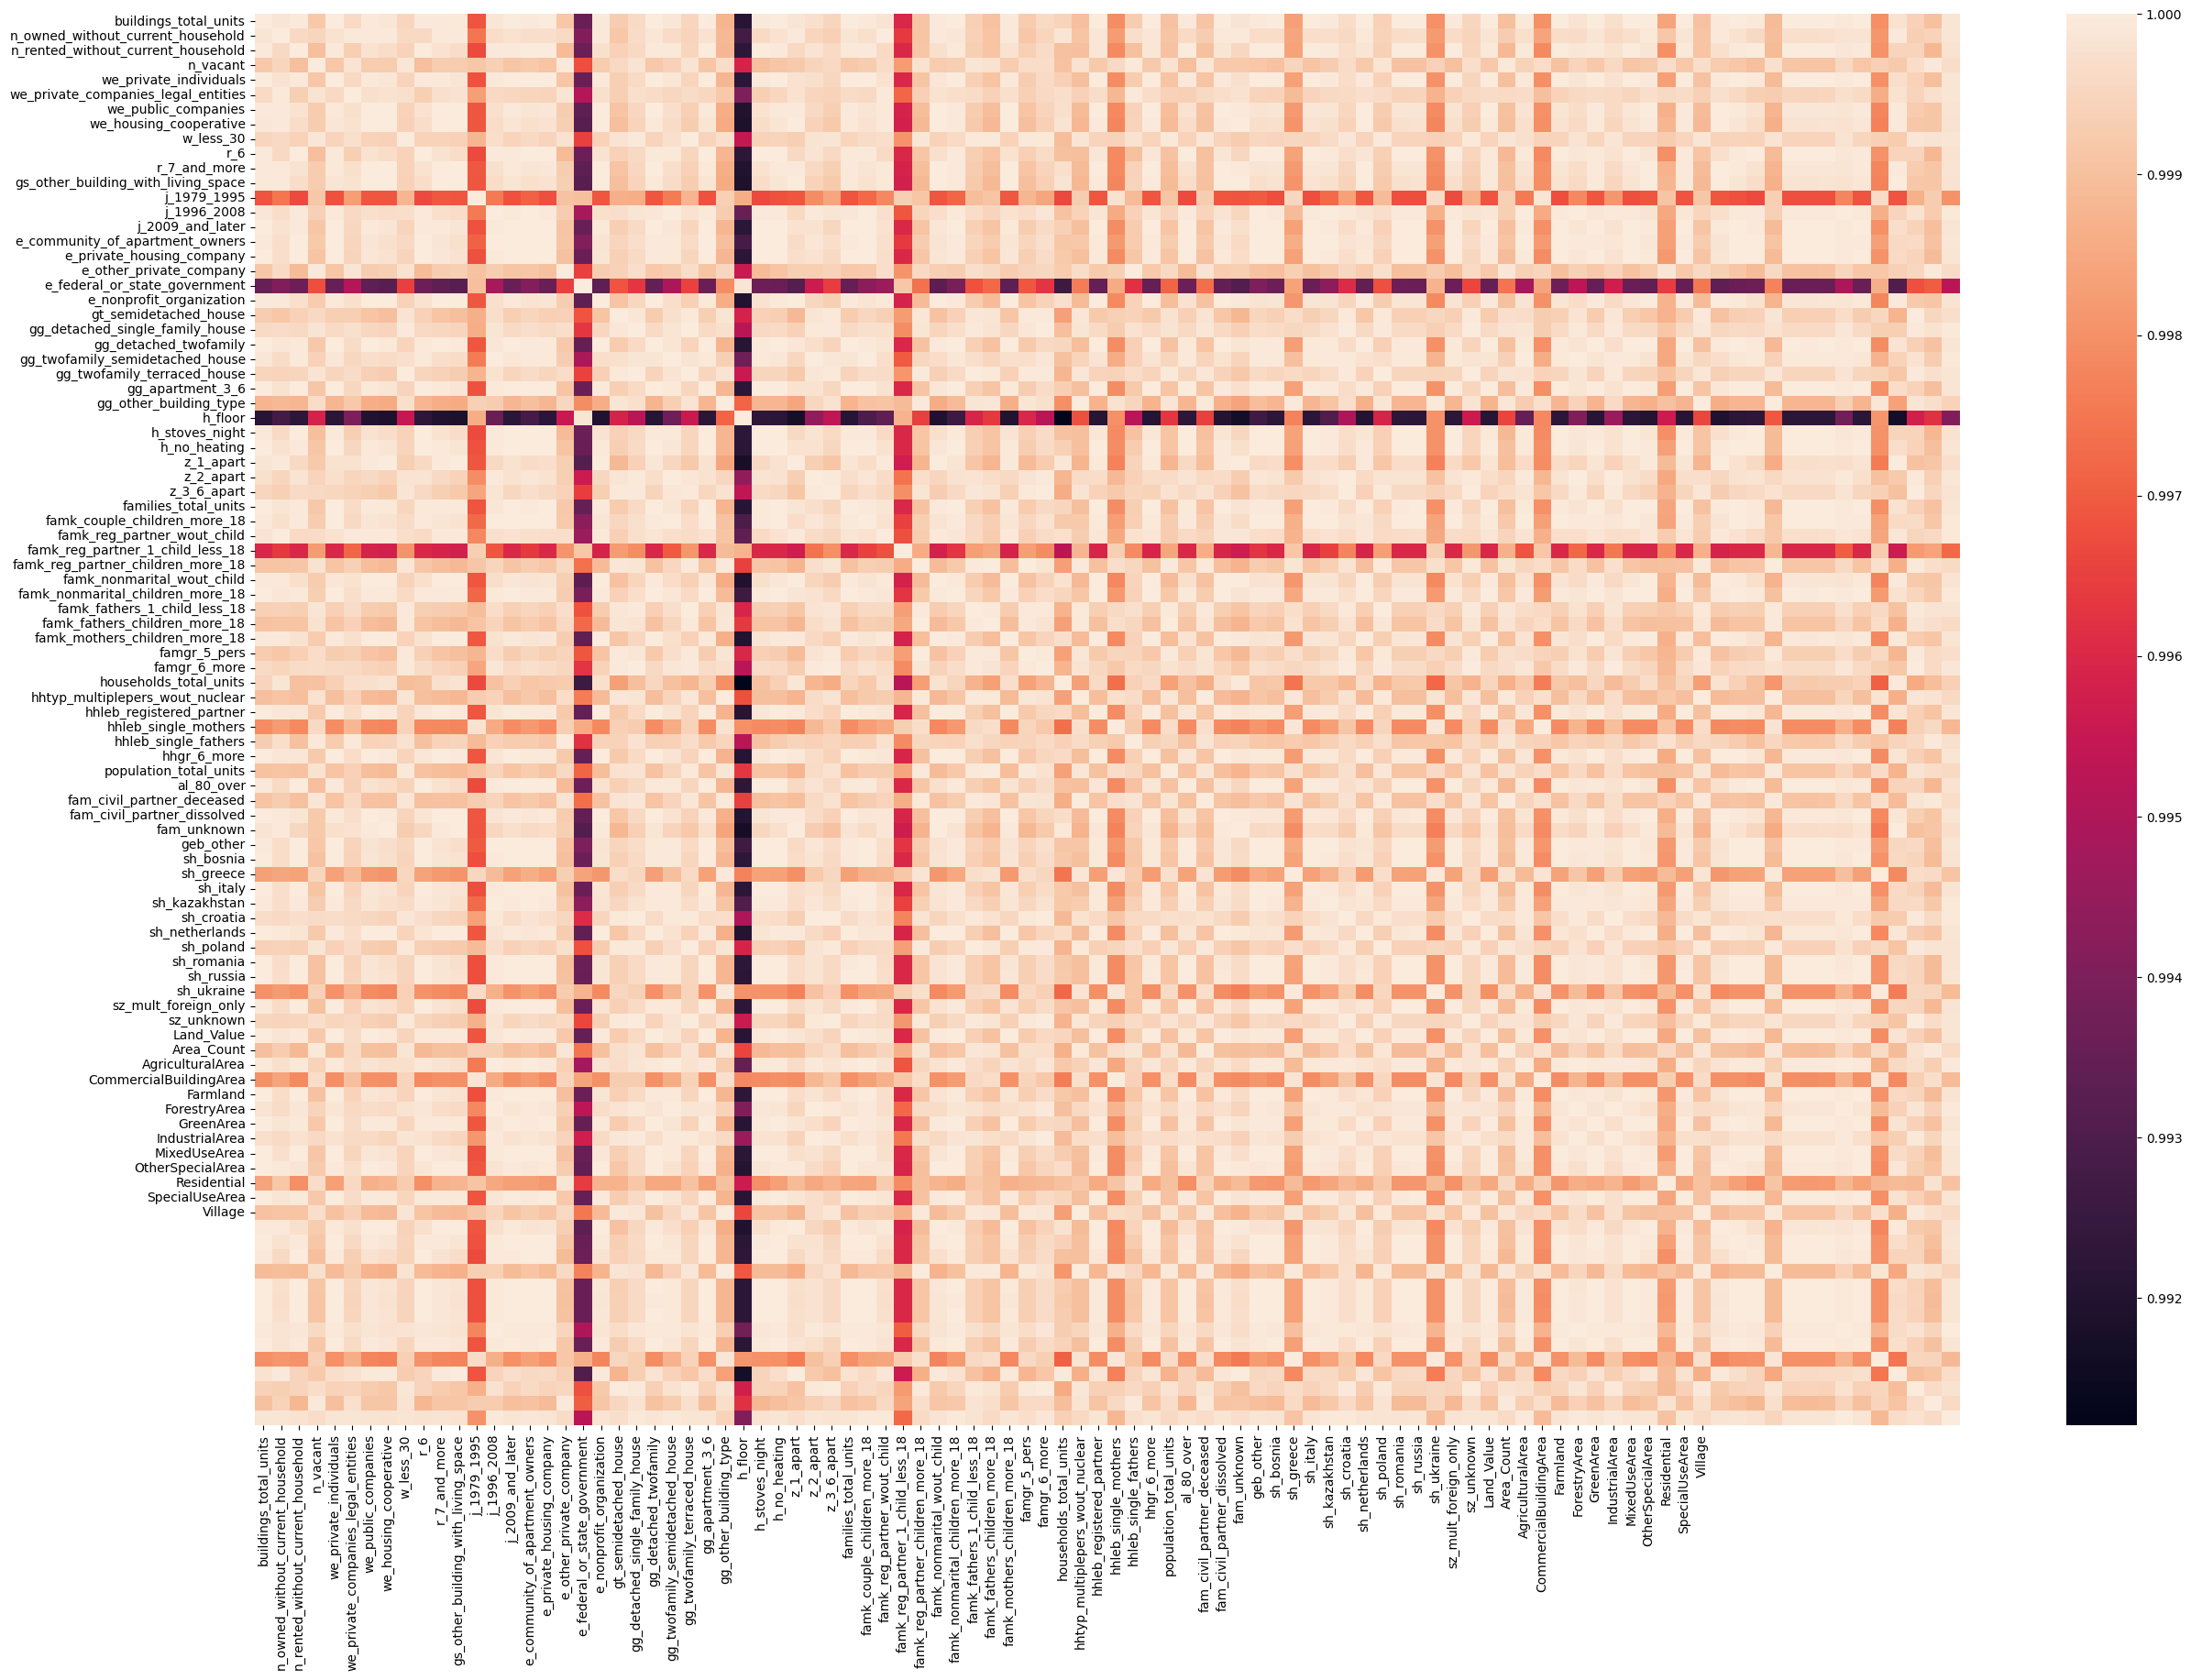

In [254]:
# calculate the correlation matrix
corr = np.corrcoef(df_berlin)


plt.figure(figsize=(30,20))
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=df_berlin.columns,
        yticklabels=df_berlin.columns)

plt.show

In [255]:
print("Most important feature due to PCA is: " + ls_df_cities_important_features[2]["features"][0] + " with a variance of "
 + str(ls_df_cities_important_features[0]["explained_variance"][0]))

Most important feature due to PCA is: population_total_units with a variance of 52.84115773250389


In [282]:
y = df_berlin["Land_Value"].values.reshape(-1, 1)
X = df_berlin.drop(columns = ["Land_Value"]).values #'hhtyp_multiplepers_wout_nuclear',

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

In [283]:
names = df_berlin.drop(columns = ["Land_Value"]).columns
reg = RandomForestRegressor(random_state = 1234567)
reg.fit(X, y)

df_important_features_berlin = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), reg.feature_importances_), names), 
             reverse=True), columns = ["value", "feature"]).head()
df_important_features_berlin


C:\Users\ferdi\AppData\Local\Temp\ipykernel_14848\1980692543.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X, y)


,value,feature
0,0.2551,buildings_total_units
1,0.2069,Area_Count
2,0.1756,MixedUseArea
3,0.1090,households_total_units
4,0.0945,CommercialBuildingArea


In [284]:
y = df_berlin["Land_Value"].values.reshape(-1, 1)
X = df_berlin.drop(columns = ["Land_Value"])[df_important_features_berlin["feature"].tolist()].values #'hhtyp_multiplepers_wout_nuclear',

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)


In [285]:

training_values = sm.add_constant(X_scaled)
est = sm.OLS(y_scaled, training_values)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     18.80
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           9.45e-13
Time:                        08:43:34   Log-Likelihood:                -101.90
No. Observations:                  96   AIC:                             215.8
Df Residuals:                      90   BIC:                             231.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.012e-16      0.074  -2.73e-15      1.0

In [286]:
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 [508.35380326]
Coefficients: 
 [[ 303.06112457   47.23358513 1306.79346993 -276.44494376 -665.61445397]]


In [287]:
scores = cross_val_score(regr, X_scaled, y_scaled, cv = 5)
scores

array([ 0.39543901, -0.01552832,  0.48641475,  0.58082317,  0.27347505])

In [288]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.34 (+/- 0.41)


### Bremen

In [171]:
df_bremen = ls_df_cities[1].drop(columns = ["geometry", "City_Name", "City_Code", "index_right", "Neighborhood_FID", "District_Name", 
"Neighborhood_Code", "District_Code"])

<function matplotlib.pyplot.show(close=None, block=None)>

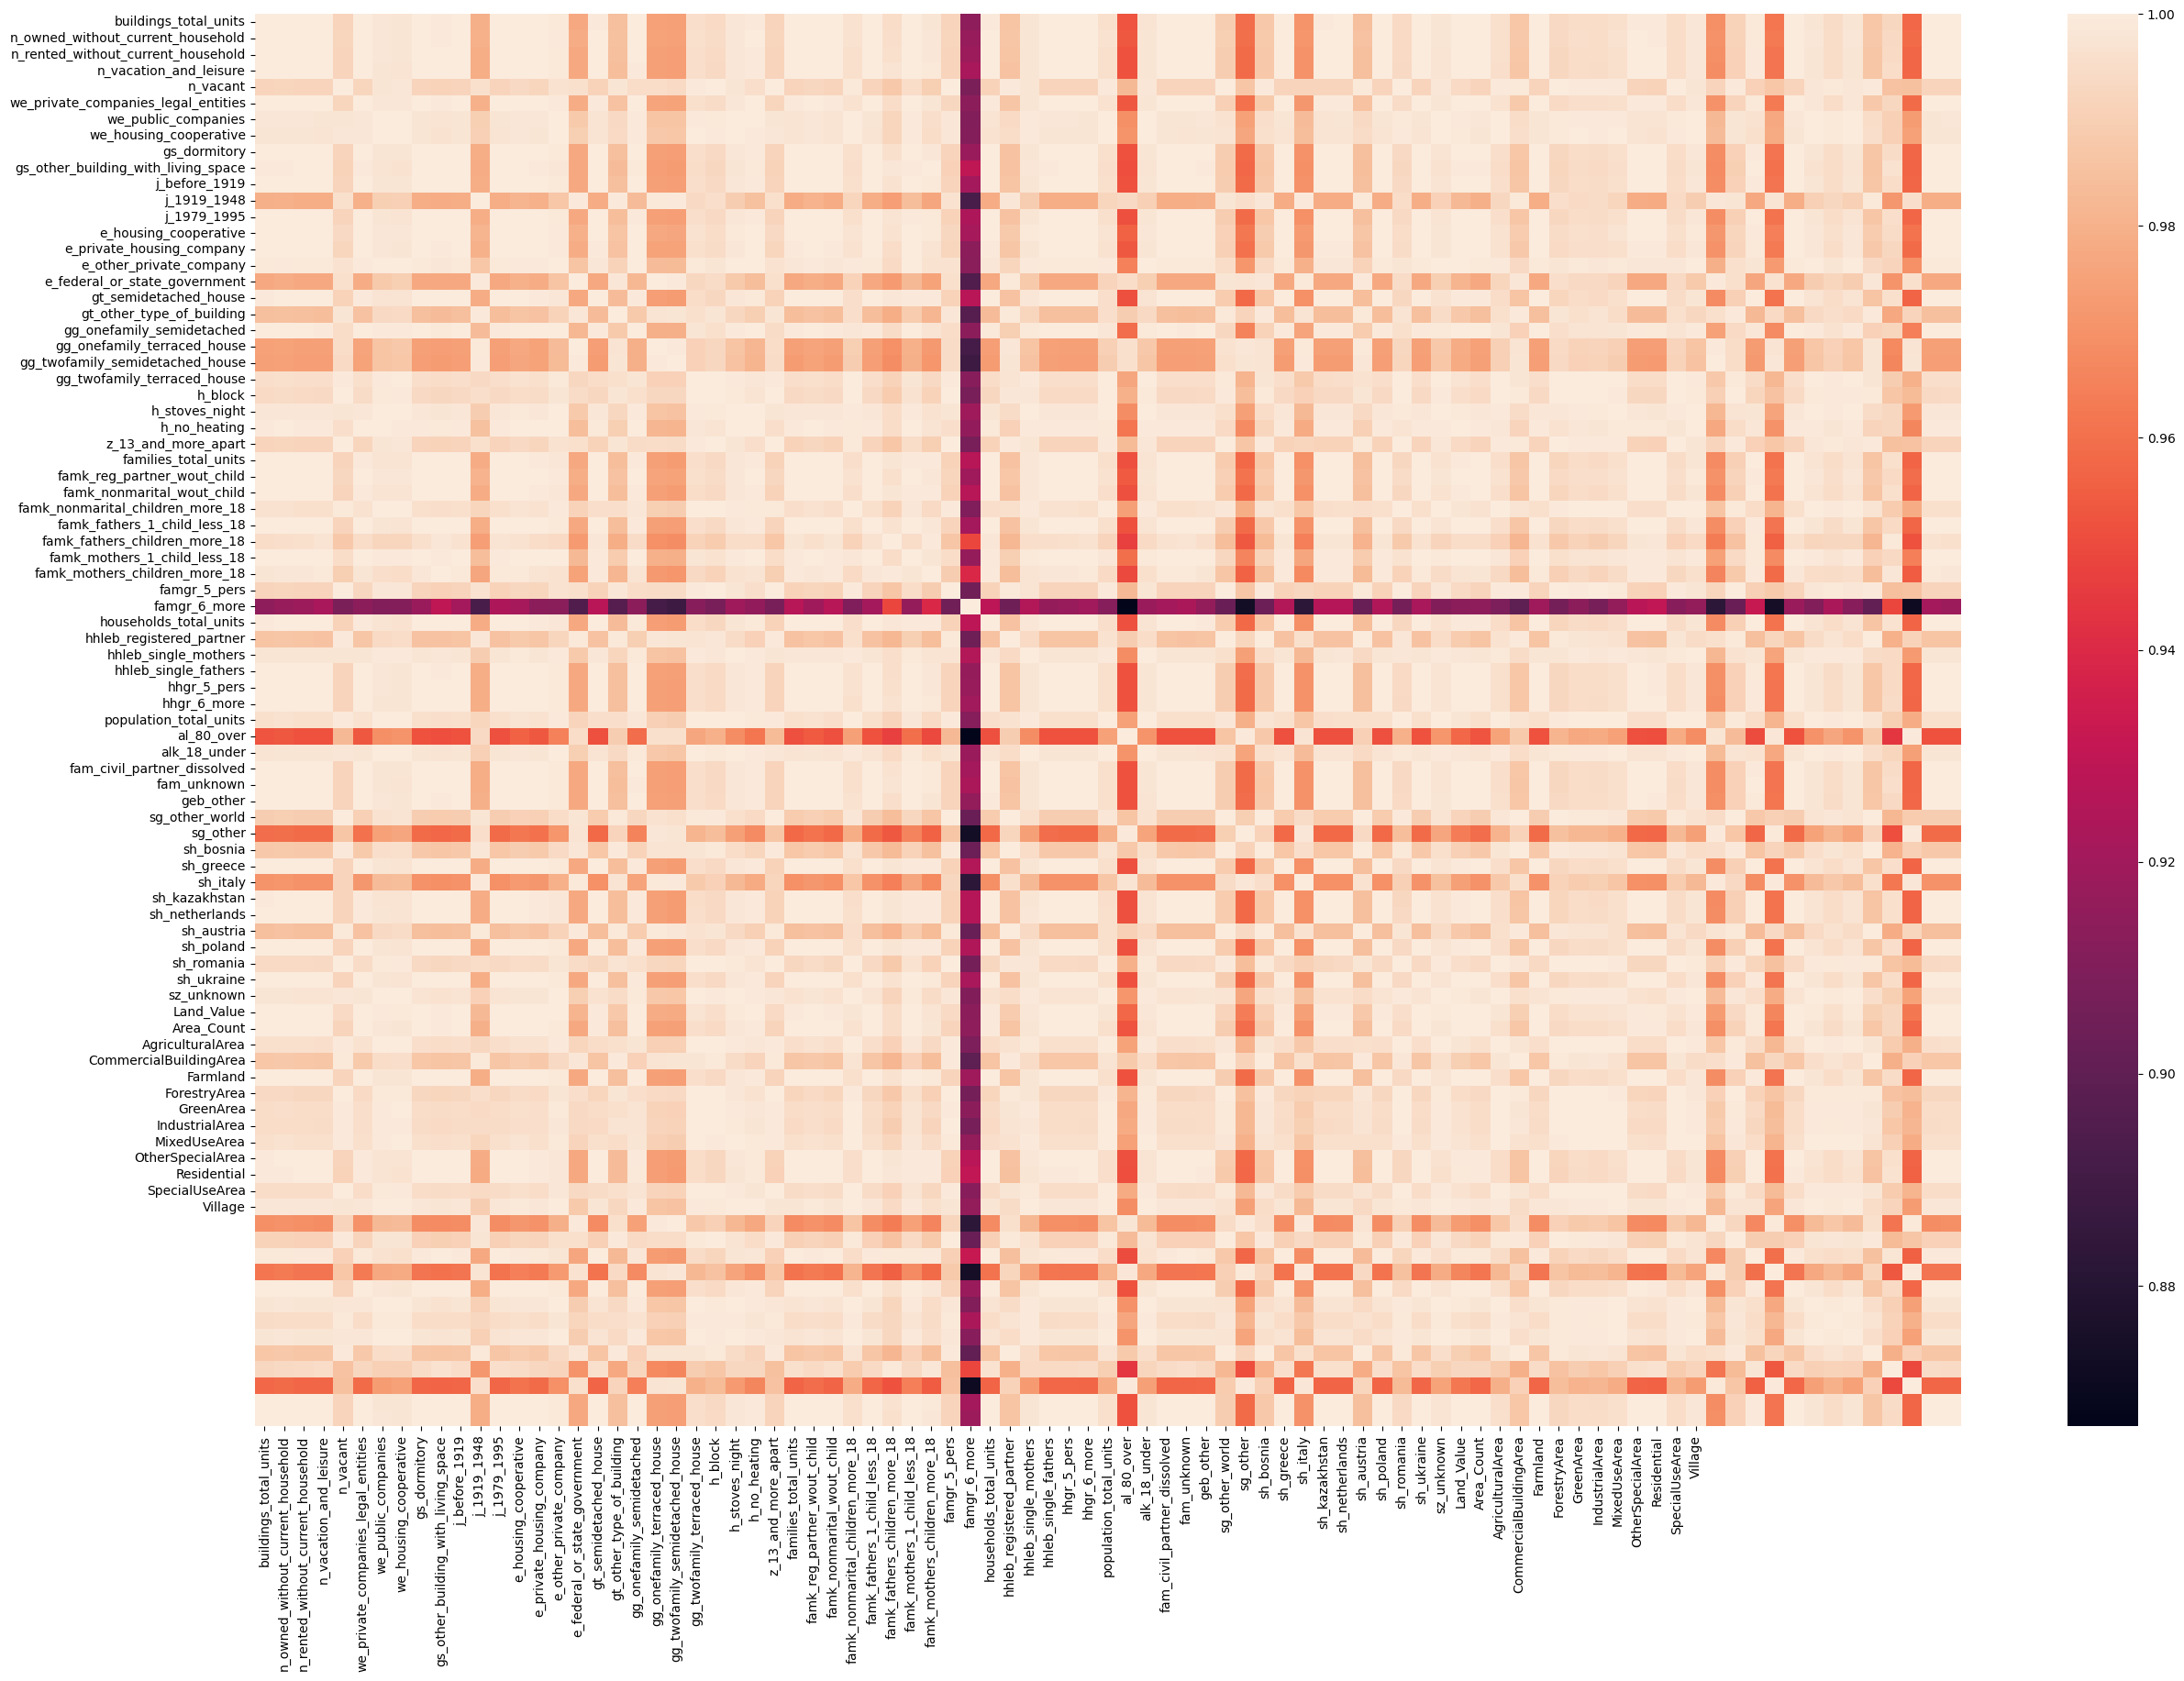

In [172]:
corr = np.corrcoef(df_bremen)


plt.figure(figsize=(30,20))
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=df_bremen.columns,
        yticklabels=df_bremen.columns)

plt.show

In [173]:
print("Most important feature due to PCA is: " + ls_df_cities_important_features[2]["features"][0] + " with a variance of "
 + str(ls_df_cities_important_features[1]["explained_variance"][0]))

Most important feature due to PCA is: population_total_units with a variance of 51.610156931539606


In [174]:
y = df_bremen["Land_Value"].values.reshape(-1, 1)
X = df_bremen.drop(columns = ["Land_Value"]).values #'hhtyp_multiplepers_wout_nuclear',

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)


In [175]:
names = df_bremen.drop(columns = ["Land_Value"]).columns
reg = RandomForestRegressor()
reg.fit(X, y)

df_important_features_bremen = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), reg.feature_importances_), names), 
             reverse=True), columns = ["value", "feature"]).head()
df_important_features_bremen

C:\Users\ferdi\AppData\Local\Temp\ipykernel_14848\1643539625.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X, y)


,value,feature
0,0.2132,j_before_1919
1,0.1999,Area_Count
2,0.1466,households_total_units
3,0.0947,population_total_units
4,0.0700,buildings_total_units


In [176]:
y = df_bremen["Land_Value"].values.reshape(-1, 1)
X = df_bremen.drop(columns = ["Land_Value"])[df_important_features_bremen["feature"].tolist()].values #'hhtyp_multiplepers_wout_nuclear',

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

In [177]:
training_values = sm.add_constant(X_scaled)
est = sm.OLS(y_scaled, training_values)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     10.64
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           7.07e-08
Time:                        08:33:37   Log-Likelihood:                -101.49
No. Observations:                  87   AIC:                             215.0
Df Residuals:                      81   BIC:                             229.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.057e-16      0.086  -3.54e-15      1.0

In [178]:
scores = cross_val_score(regr, X_scaled, y_scaled, cv = 5)
scores

array([-0.09662829, -0.14759405, -0.76413017,  0.45728602,  0.41364487])

In [179]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.03 (+/- 0.89)


### Dresden

In [180]:
df_dresden = ls_df_cities[2].drop(columns = ["geometry", "City_Name", "City_Code", "index_right", "Neighborhood_FID", "Neighborhood_Code"])

<function matplotlib.pyplot.show(close=None, block=None)>

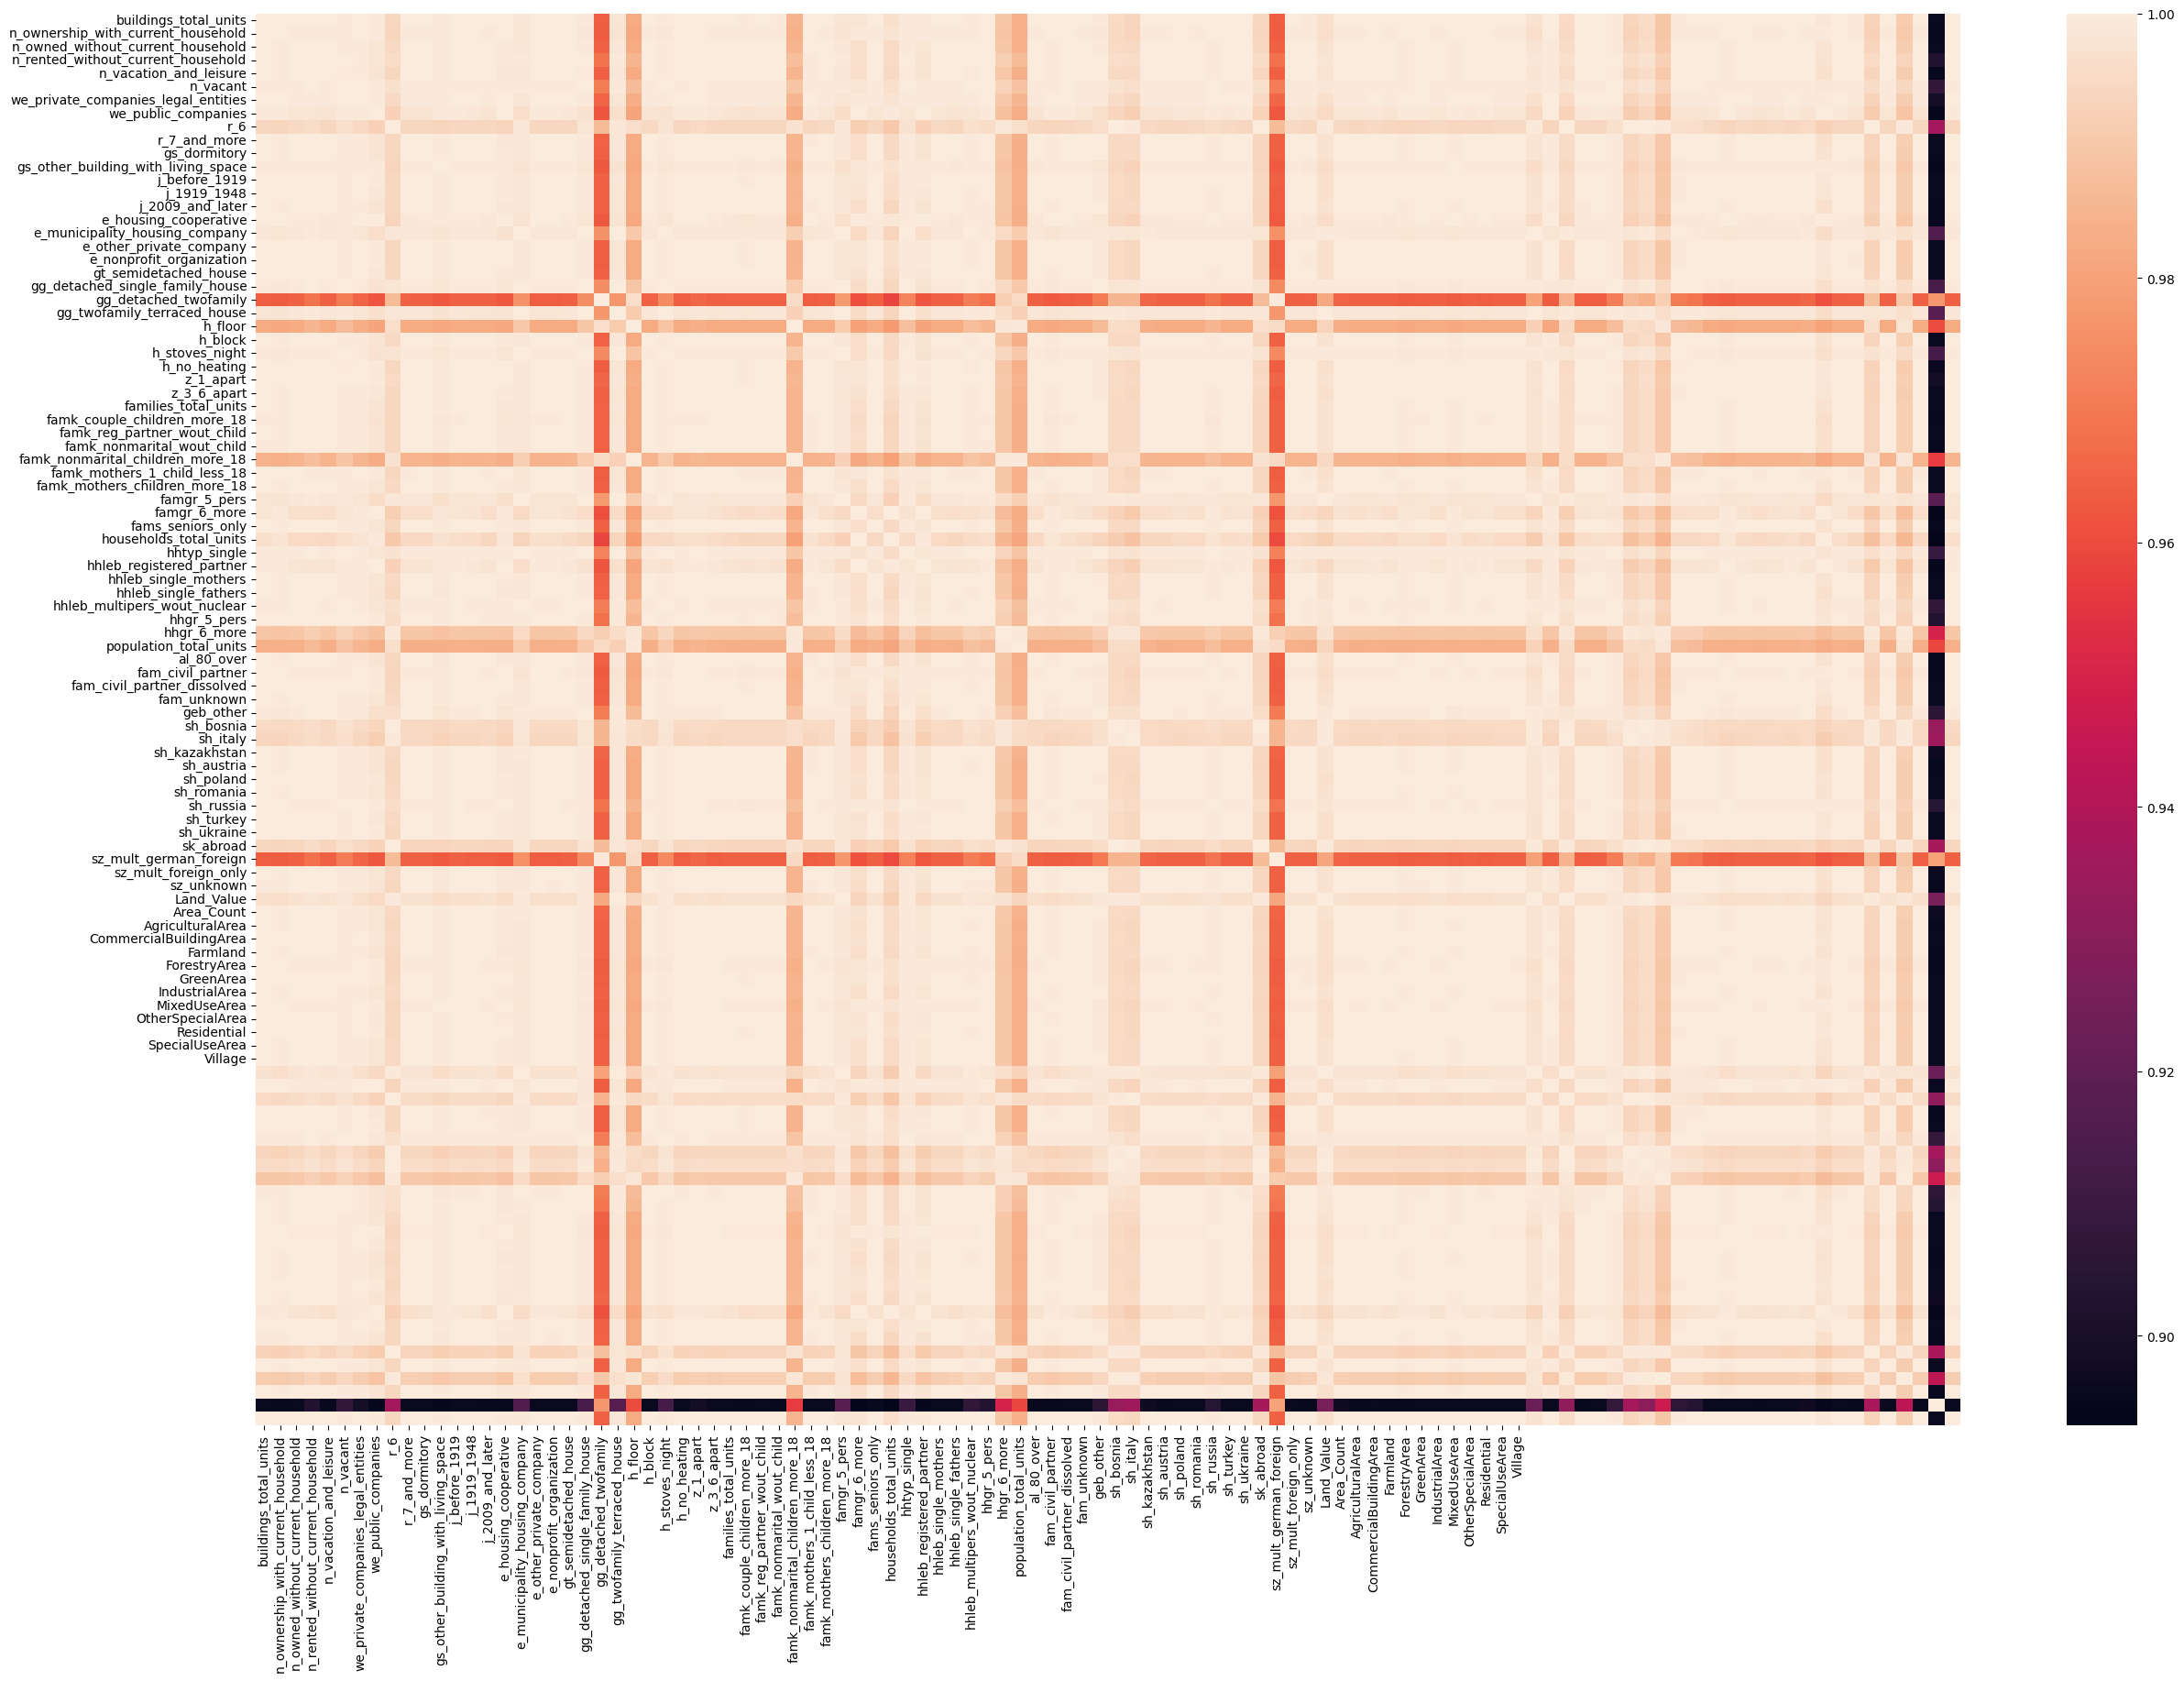

In [181]:
corr = np.corrcoef(df_dresden)


plt.figure(figsize=(30,20))
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=df_dresden.columns,
        yticklabels=df_dresden.columns)

plt.show

In [182]:
print("Most important feature due to PCA is: " + ls_df_cities_important_features[2]["features"][0] + " with a variance of "
 + str(ls_df_cities_important_features[2]["explained_variance"][0]))

Most important feature due to PCA is: population_total_units with a variance of 46.13699897225184


In [183]:
y = df_dresden["Land_Value"].values.reshape(-1, 1)
X = df_dresden.drop(columns = ["Land_Value"]).values #'hhtyp_multiplepers_wout_nuclear',

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

In [184]:
names = df_dresden.drop(columns = ["Land_Value"]).columns
reg = RandomForestRegressor()
reg.fit(X, y)

df_important_features_dresden = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), reg.feature_importances_), names), 
             reverse=True), columns = ["value", "feature"]).head()
df_important_features_dresden

C:\Users\ferdi\AppData\Local\Temp\ipykernel_14848\2801673008.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X, y)


,value,feature
0,0.3169,Residential
1,0.2850,MixedUseArea
2,0.1590,Area_Count
3,0.0698,population_total_units
4,0.0318,AgriculturalArea


In [185]:
y = df_dresden["Land_Value"].values.reshape(-1, 1)
X = df_dresden.drop(columns = ["Land_Value"])[df_important_features_dresden["feature"].tolist()].values #'hhtyp_multiplepers_wout_nuclear',

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

In [186]:
training_values = sm.add_constant(X_scaled)
est = sm.OLS(y_scaled, training_values)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     13.70
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           3.47e-10
Time:                        08:35:53   Log-Likelihood:                -122.75
No. Observations:                 106   AIC:                             257.5
Df Residuals:                     100   BIC:                             273.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.286e-17      0.077  -9.46e-16      1.0

In [187]:
scores = cross_val_score(regr, X_scaled, y_scaled, cv = 5)
scores

array([-5.56651812, -0.00642009, -1.01970819,  0.6398322 ,  0.50626377])

In [188]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -1.09 (+/- 4.63)


### Frankfurt am Main

In [194]:
df_frankfurt = ls_df_cities[3].drop(columns = ["geometry", "City_Name", "City_Code", "Neighborhood_FID", "index_right"])

<function matplotlib.pyplot.show(close=None, block=None)>

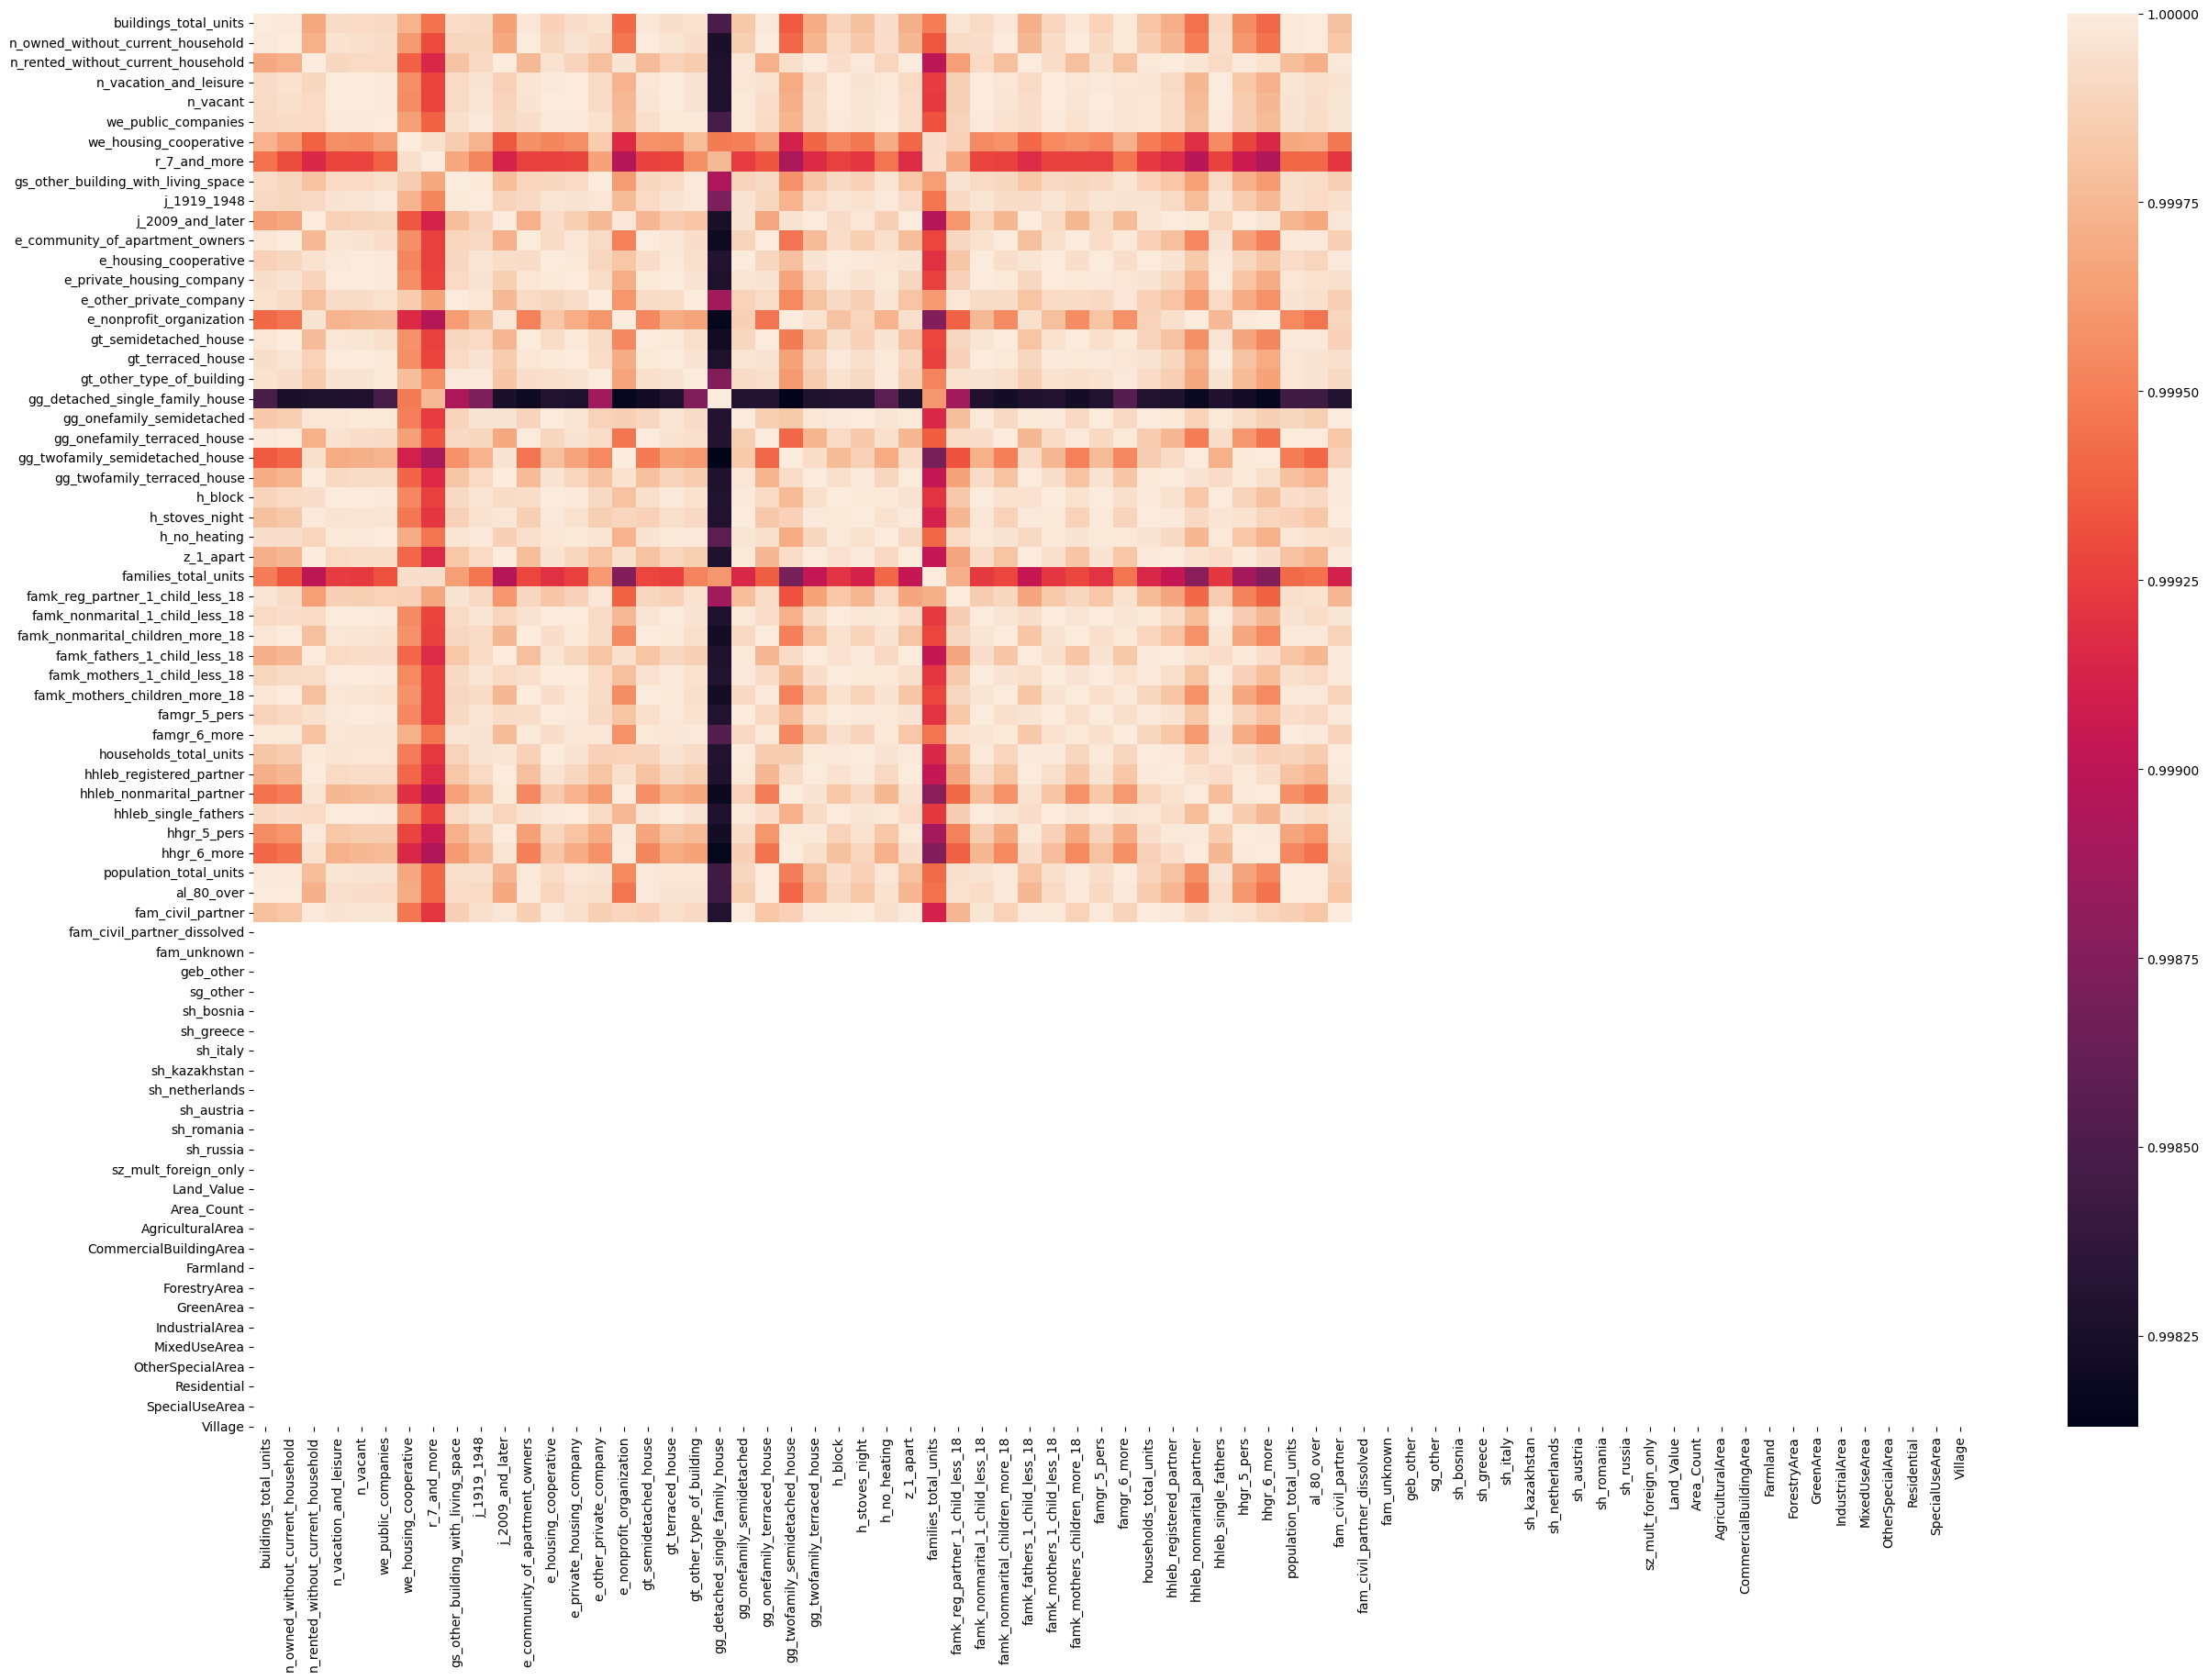

In [195]:
corr = np.corrcoef(df_frankfurt)


plt.figure(figsize=(30,20))
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=df_frankfurt.columns,
        yticklabels=df_frankfurt.columns)

plt.show

In [196]:
print("Most important feature due to PCA is: " + ls_df_cities_important_features[2]["features"][0] + " with a variance of "
 + str(ls_df_cities_important_features[3]["explained_variance"][0]))

Most important feature due to PCA is: population_total_units with a variance of 56.95094795067678


In [197]:
y = df_frankfurt["Land_Value"].values.reshape(-1, 1)
X = df_frankfurt.drop(columns = ["Land_Value"]).values #'hhtyp_multiplepers_wout_nuclear',

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

In [198]:
names = df_frankfurt.drop(columns = ["Land_Value"]).columns
reg = RandomForestRegressor()
reg.fit(X, y)

df_important_features_frankfurt = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), reg.feature_importances_), names), 
             reverse=True), columns = ["value", "feature"]).head()
df_important_features_frankfurt

C:\Users\ferdi\AppData\Local\Temp\ipykernel_14848\1288838945.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X, y)


,value,feature
0,0.2373,buildings_total_units
1,0.1807,households_total_units
2,0.1657,Area_Count
3,0.1481,population_total_units
4,0.0827,families_total_units


In [199]:
y = df_frankfurt["Land_Value"].values.reshape(-1, 1)
X = df_frankfurt.drop(columns = ["Land_Value"])[df_important_features_frankfurt["feature"].tolist()].values #'hhtyp_multiplepers_wout_nuclear',

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

In [200]:
training_values = sm.add_constant(X_scaled)
est = sm.OLS(y_scaled, training_values)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     11.01
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           1.04e-06
Time:                        08:38:06   Log-Likelihood:                -45.367
No. Observations:                  46   AIC:                             102.7
Df Residuals:                      40   BIC:                             113.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.551e-17      0.103   5.41e-16      1.0

In [201]:
scores = cross_val_score(regr, X_scaled, y_scaled, cv = 5)
scores

array([ 0.33042739, -0.37406093,  0.50386207, -6.16647527, -0.04556462])

In [202]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -1.15 (+/- 5.05)


### Koeln

In [212]:
df_koeln = ls_df_cities[4].drop(columns = ["geometry", "City_Name", "City_Code", "Neighborhood_FID", "District_Name", "index_right"])

<function matplotlib.pyplot.show(close=None, block=None)>

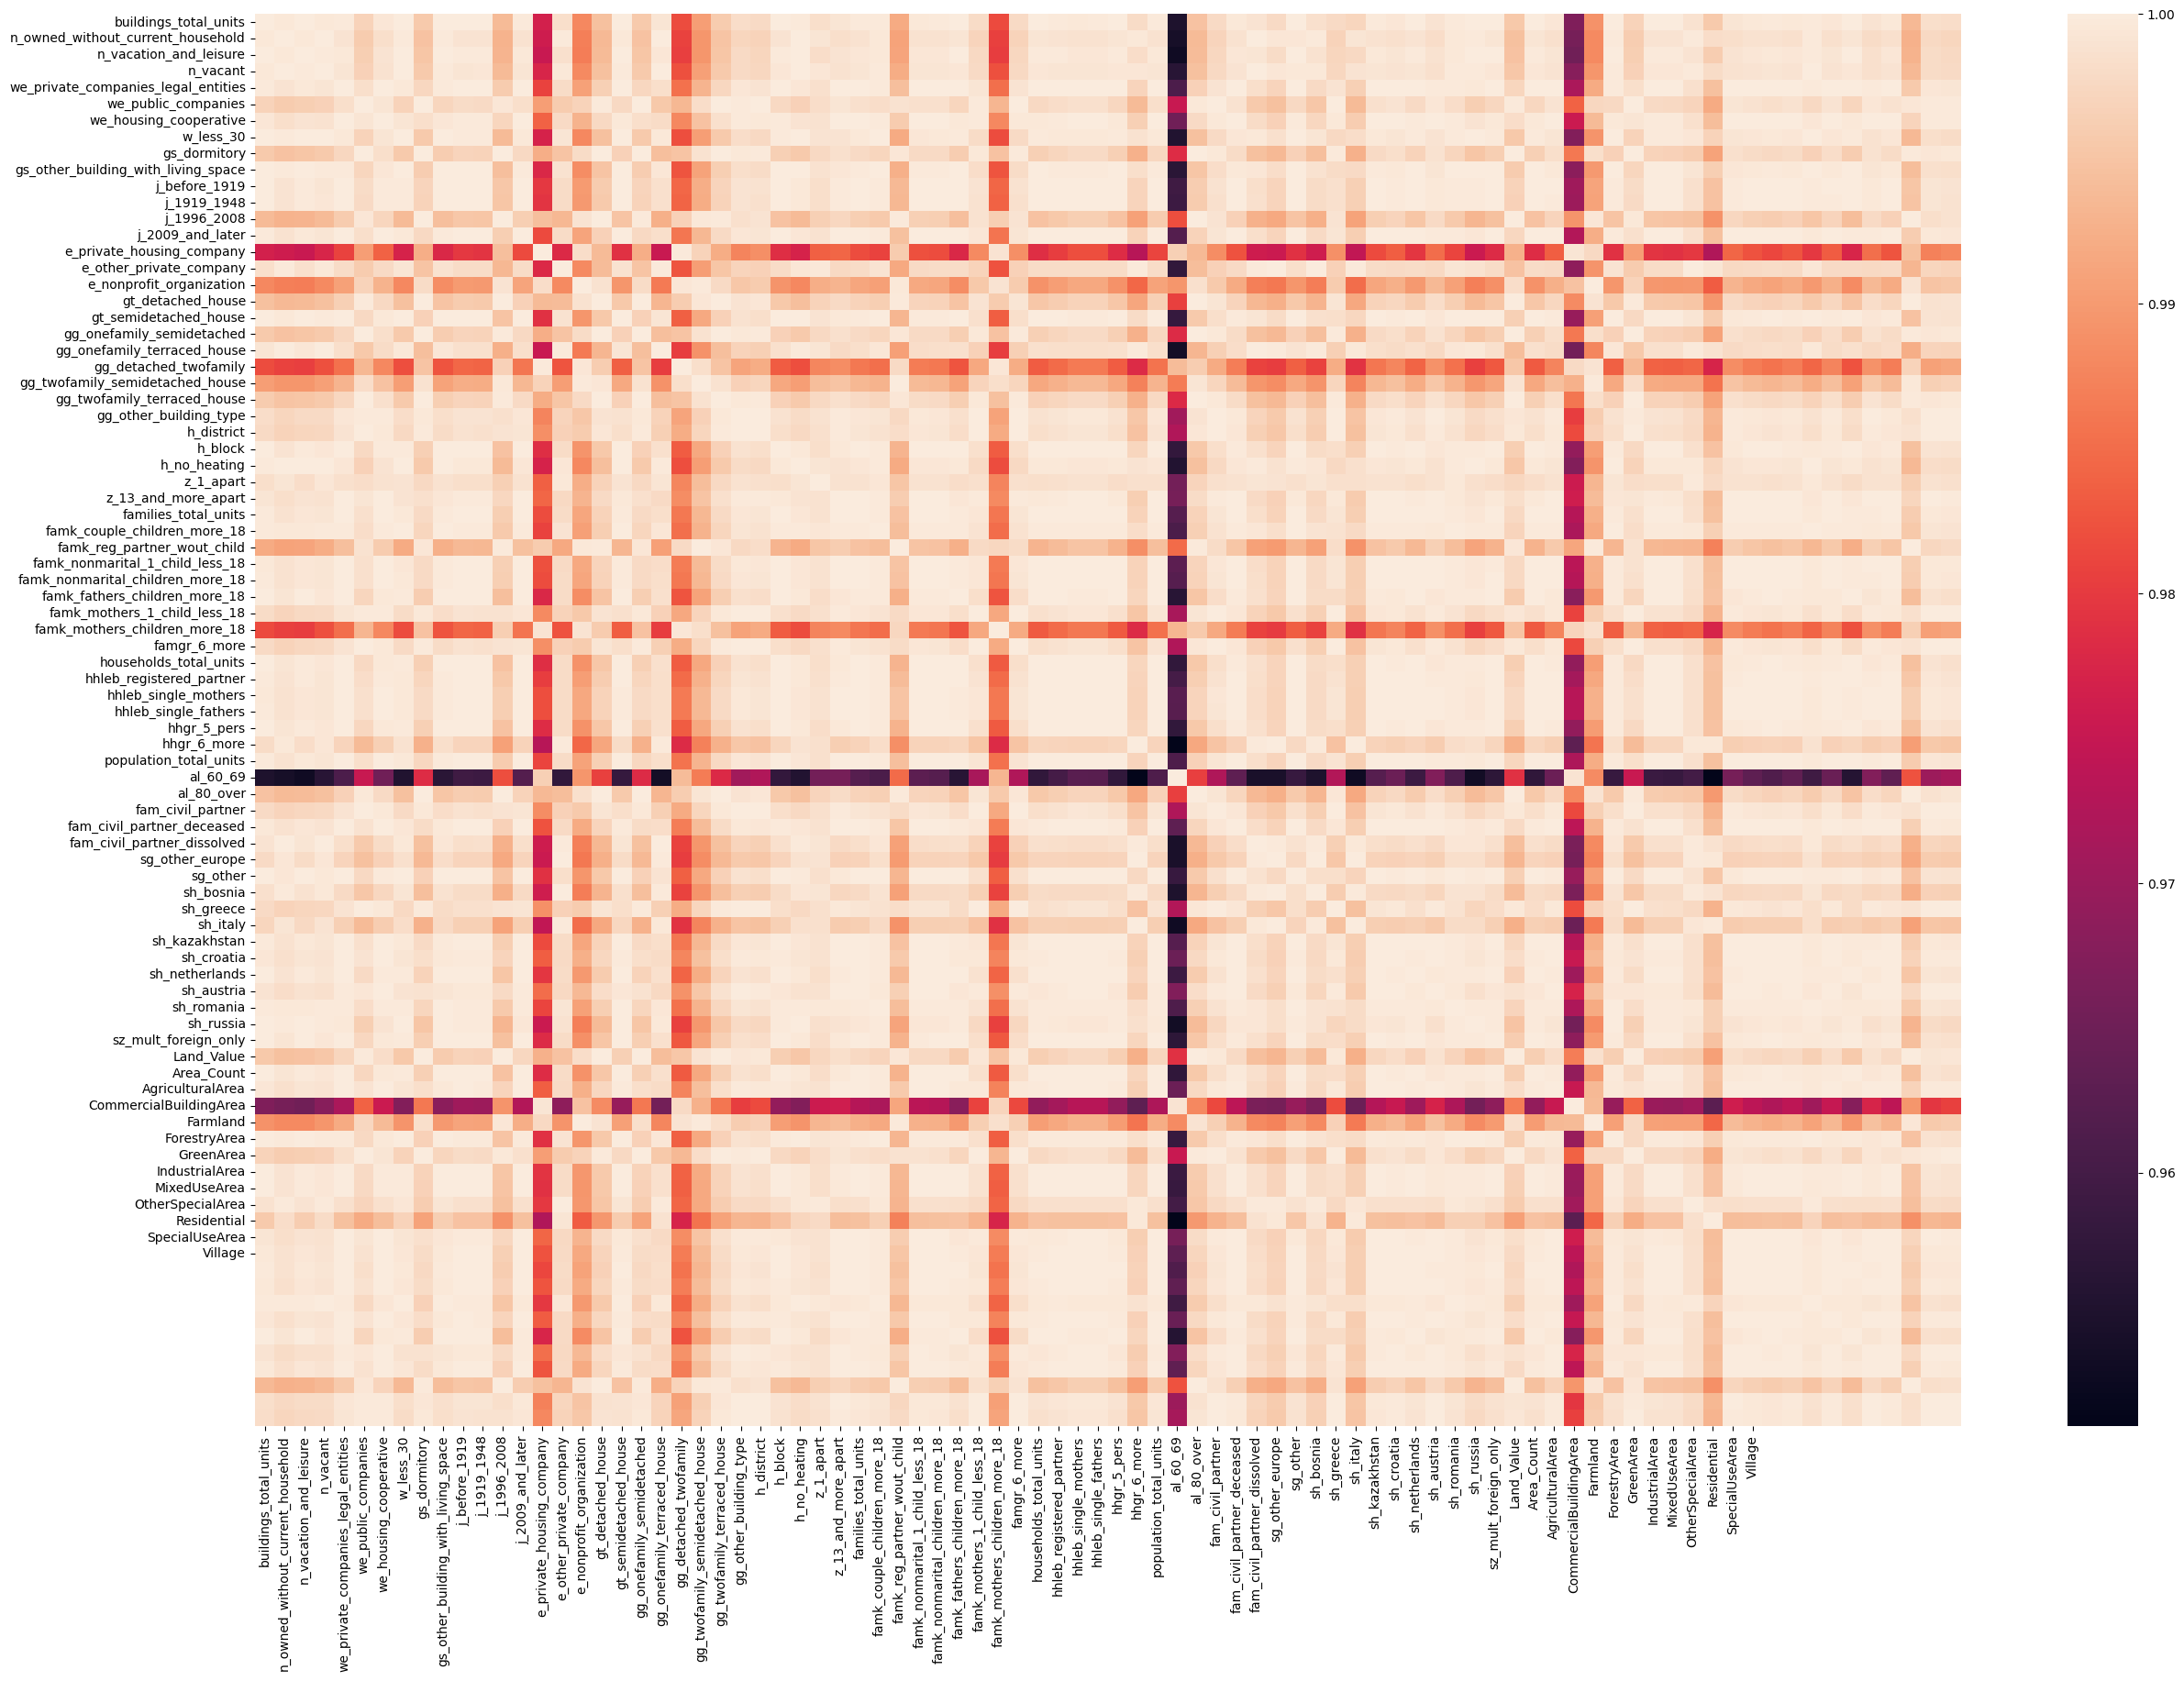

In [213]:
corr = np.corrcoef(df_koeln)


plt.figure(figsize=(30,20))
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=df_koeln.columns,
        yticklabels=df_koeln.columns)

plt.show

In [214]:
print("Most important feature due to PCA is: " + ls_df_cities_important_features[2]["features"][0] + " with a variance of "
 + str(ls_df_cities_important_features[4]["explained_variance"][0]))

Most important feature due to PCA is: population_total_units with a variance of 55.125469168206145


In [215]:
y = df_koeln["Land_Value"].values.reshape(-1, 1)
X = df_koeln.drop(columns = ["Land_Value"]).values #'hhtyp_multiplepers_wout_nuclear',

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

In [242]:
names = df_koeln.drop(columns = ["Land_Value"]).columns
reg = RandomForestRegressor() 
reg.fit(X, y)

df_important_features_koeln = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), reg.feature_importances_), names), 
             reverse=True), columns = ["value", "feature"]).head()
df_important_features_koeln

C:\Users\ferdi\AppData\Local\Temp\ipykernel_14848\1226317854.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X, y)


,value,feature
0,1.0,we_private_companies_legal_entities
1,0.0,n_vacation_and_leisure
2,0.0,n_vacant
3,0.0,n_owned_without_current_household
4,0.0,buildings_total_units


In [243]:
y = df_koeln["Land_Value"].values.reshape(-1, 1)
X = df_koeln.drop(columns = ["Land_Value"])[df_important_features_koeln["feature"].tolist()].values #'hhtyp_multiplepers_wout_nuclear',

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

In [244]:
training_values = sm.add_constant(X_scaled)
est = sm.OLS(y_scaled, training_values)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     42.81
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           4.49e-09
Time:                        08:42:07   Log-Likelihood:                -104.32
No. Observations:                  86   AIC:                             212.6
Df Residuals:                      84   BIC:                             217.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.266e-16      0.089  -1.43e-15      1.0

c:\Users\ferdi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [245]:
scores = cross_val_score(regr, X_scaled, y_scaled, cv = 5)
scores

array([ 0.19195126, -0.17789522, -0.05573298,  0.07784027, -0.34988504])

In [246]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.06 (+/- 0.38)
